#### By: Peyman Shahidi
#### Created: Oct 9, 2025
#### Last Edit: Oct 18, 2025

<br>

In [49]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [50]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots"

In [51]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [52]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Remove apostrophes for consistency
ONET = ONET.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Drop  columns to avoid double counting
# Note: In ~4k instances, the same task is mapped to multiple DWAs
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# Remove duplicate rows
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates().reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

ONET.head(5)

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Relevance,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organizations financia...,Core,5,9.62,124.47,38.46,62.90,...,94.19,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,98.79,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,100.00,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,95.84,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,90.47,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


In [53]:
# Load GPTs are GPTs full label dataset
gpts_full_labels = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")
# Drop the first column
gpts_full_labels = gpts_full_labels.drop(gpts_full_labels.columns[:1], axis=1)

# Convert Task ID to integer
gpts_full_labels['Task ID'] = gpts_full_labels['Task ID'].astype(int)

# Remove apostrophes for consistency
gpts_full_labels = gpts_full_labels.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Rename columns
gpts_full_labels = gpts_full_labels.rename(columns={
    'Task': 'Task Title',
    'Title': 'Occupation Title'
})

# Print length of dataset
print(f"Number of rows in GPTs full labels dataset: {len(gpts_full_labels):,}")


gpts_full_labels.head(5)

Number of rows in GPTs full labels dataset: 19,265


,O*NET-SOC Code,Task ID,Task Title,Task Type,Occupation Title,human_exposure_agg,gpt4_exposure,gpt4_exposure_alt_rubric,gpt_3_relevant,gpt4_automation,alpha,beta,gamma,automation,human_labels
0,11-1011.00,8823,Direct or coordinate an organizations financia...,Core,Chief Executives,E0,E2,E2,False,T2,0.00,0.50,1.00,0.50,E0
1,11-1011.00,8831,Appoint department heads or managers and assig...,Core,Chief Executives,E0,E0,E0,False,T1,0.00,0.00,0.00,0.25,E0
2,11-1011.00,8825,Analyze operations to evaluate performance of ...,Core,Chief Executives,E2,E2,E2,False,T2,0.00,0.50,1.00,0.50,E2
3,11-1011.00,8826,"Direct, plan, or implement policies, objective...",Core,Chief Executives,E0,E2,E0,False,T1,0.00,0.50,1.00,0.25,E0
4,11-1011.00,8827,"Prepare budgets for approval, including those ...",Core,Chief Executives,E2,E2,E2,False,T2,0.00,0.50,1.00,0.50,E2


In [54]:
# Merge with ONET dataset to get hierarchical codes and titles
ONET = ONET.merge(gpts_full_labels, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], how='left')

# Check how many tasks were not matched
unmatched_tasks = ONET[ONET['gpt4_exposure'].isna()]
print(f"Number of unmatched tasks: {len(unmatched_tasks):,}")

Number of unmatched tasks: 0


In [55]:
# Drop the supplemental tasks
ONET = ONET[ONET['Task Type'] != 'Supplemental'].reset_index(drop=True)

# Drop rows whose Occupation Title includes 'Teachers, Postsecondary'
ONET = ONET[~ONET['Occupation Title'].str.contains('Teachers, Postsecondary')].reset_index(drop=True)

## Replication of Eloundou et al. (2024) Measures

In [56]:
# Reconstruct the occ_level exposure dataset from the original paper
def compute_exposure_shares(df, exposure_col, prefix):
    # Weight core vs. supplemental tasks (if column exists)
    df["task_weight"] = df["Task Type"].map({"Core": 1.0, "Supplemental": 0.5}).fillna(1.0)

    # One-hot exposure indicators
    df[f"{prefix}_E1"] = (df[exposure_col] == "E1").astype(int)
    df[f"{prefix}_E2"] = (df[exposure_col] == "E2").astype(int)

    # Weighted shares per occupation
    occ_level = (
        df.groupby(["O*NET-SOC Code", "Occupation Title"])
        .apply(lambda x: pd.Series({
            f"{prefix}_E1_share": (x[f"{prefix}_E1"] * x["task_weight"]).sum() / x["task_weight"].sum(),
            f"{prefix}_E2_share": (x[f"{prefix}_E2"] * x["task_weight"]).sum() / x["task_weight"].sum(),
        }))
        .reset_index()
    )

    # Composite measures
    occ_level[f"{prefix}_E1_plus_halfE2"] = occ_level[f"{prefix}_E1_share"] + 0.5 * occ_level[f"{prefix}_E2_share"]
    occ_level[f"{prefix}_E1_plus_E2"]     = occ_level[f"{prefix}_E1_share"] + occ_level[f"{prefix}_E2_share"]

    occ_level = occ_level.drop(columns=[f'{prefix}_E2_share'])

    occ_level = occ_level.rename(columns={'gpt4_E1_share': 'gpt4_alpha',
                                          'gpt4_E1_plus_halfE2': 'gpt4_beta',
                                          'gpt4_E1_plus_E2': 'gpt4_gamma',
                                          'human_E1_share': 'human_alpha',
                                          'human_E1_plus_halfE2': 'human_beta',
                                          'human_E1_plus_E2': 'human_gamma'})

    return occ_level


# Compute exposure shares for GPT-4 and human ratings
gpt4_exposure_scores = compute_exposure_shares(ONET, "gpt4_exposure", "gpt4")
human_exposure_scores = compute_exposure_shares(ONET, "human_labels", "human")

# Merge GPT-4 and human exposure scores on occupation code and title
exposure_scores_occupation = pd.merge(gpt4_exposure_scores, human_exposure_scores, 
                                     on=["O*NET-SOC Code", "Occupation Title"])

# Save the combined exposure scores to CSV
# exposure_scores_occupation.to_csv(f'{output_data_path}/exposure_scores_occupation.csv', index=False)
# print(f"Saved combined exposure scores to: {output_data_path}/exposure_scores_occupation.csv")
print(f"Number of occupations: {len(exposure_scores_occupation)}")

# Display the results
exposure_scores_occupation.head()

Number of occupations: 837


,O*NET-SOC Code,Occupation Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma
0,11-1011.00,Chief Executives,0.11,0.47,0.84,0.21,0.37,0.53
1,11-1011.03,Chief Sustainability Officers,0.17,0.56,0.94,0.06,0.39,0.72
2,11-1021.00,General and Operations Managers,0.00,0.50,1.00,0.11,0.39,0.67
3,11-2011.00,Advertising and Promotions Managers,0.00,0.50,1.00,0.38,0.62,0.85
4,11-2021.00,Marketing Managers,0.08,0.50,0.92,0.17,0.54,0.92


### Add additional columns to replicated measures and save

In [57]:
# Enrich exposure_scores_occupation with hierarchical ONET codes/titles (Major, Minor, Broad, Detailed), add task counts, and save
print('\nAdding ONET hierarchy columns to exposure_scores_occupation and merging unique task counts; saving as ONET_tasklevel_exposure.csv')

# Select unique occupation-level mapping from ONET
occupation_map = ONET.drop_duplicates(subset=['O*NET-SOC Code', 'Occupation Title'])[[
    'O*NET-SOC Code', 'Occupation Title',
    'Major_Group_Code', 'Major_Group_Title',
    'Minor_Group_Code', 'Minor_Group_Title',
    'Broad_Occupation_Code', 'Broad_Occupation_Title',
    'Detailed_Occupation_Code', 'Detailed_Occupation_Title'
    ]]

# Merge with exposure_scores_occupation
exposure_scores_occupation = exposure_scores_occupation.merge(
    occupation_map,
    on=['O*NET-SOC Code', 'Occupation Title'],
    how='left'
    )

# Compute number of unique tasks per occupation and merge into the enriched dataset
task_counts = ONET.groupby(['O*NET-SOC Code', 'Occupation Title'])['Task ID'].nunique().reset_index()
task_counts = task_counts.rename(columns={'Task ID': 'num_unique_tasks'})

exposure_scores_occupation = exposure_scores_occupation.merge(
    task_counts,
    on=['O*NET-SOC Code', 'Occupation Title'],
    how='left'
    )

# Save to CSV
exposure_scores_occupation.to_csv(f'{output_data_path}/ONET_tasklevel_exposure.csv', index=False)
print(f"✓ Saved enriched exposure dataset with task counts to: {output_data_path}/ONET_tasklevel_exposure.csv")

# Display sample
exposure_scores_occupation.head()


Adding ONET hierarchy columns to exposure_scores_occupation and merging unique task counts; saving as ONET_tasklevel_exposure.csv
✓ Saved enriched exposure dataset with task counts to: ../data/computed_objects/ONET_tasklevel_exposure.csv


,O*NET-SOC Code,Occupation Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title,num_unique_tasks
0,11-1011.00,Chief Executives,0.11,0.47,0.84,0.21,0.37,0.53,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,19
1,11-1011.03,Chief Sustainability Officers,0.17,0.56,0.94,0.06,0.39,0.72,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,18
2,11-1021.00,General and Operations Managers,0.00,0.50,1.00,0.11,0.39,0.67,11-0000,Management Occupations,11-1000,Top Executives,11-1020,General and Operations Managers,11-1021,General and Operations Managers,9
3,11-2011.00,Advertising and Promotions Managers,0.00,0.50,1.00,0.38,0.62,0.85,11-0000,Management Occupations,11-2000,"Advertising, Marketing, Promotions, Public Rel...",11-2010,Advertising and Promotions Managers,11-2011,Advertising and Promotions Managers,13
4,11-2021.00,Marketing Managers,0.08,0.50,0.92,0.17,0.54,0.92,11-0000,Management Occupations,11-2000,"Advertising, Marketing, Promotions, Public Rel...",11-2020,Marketing and Sales Managers,11-2021,Marketing Managers,12


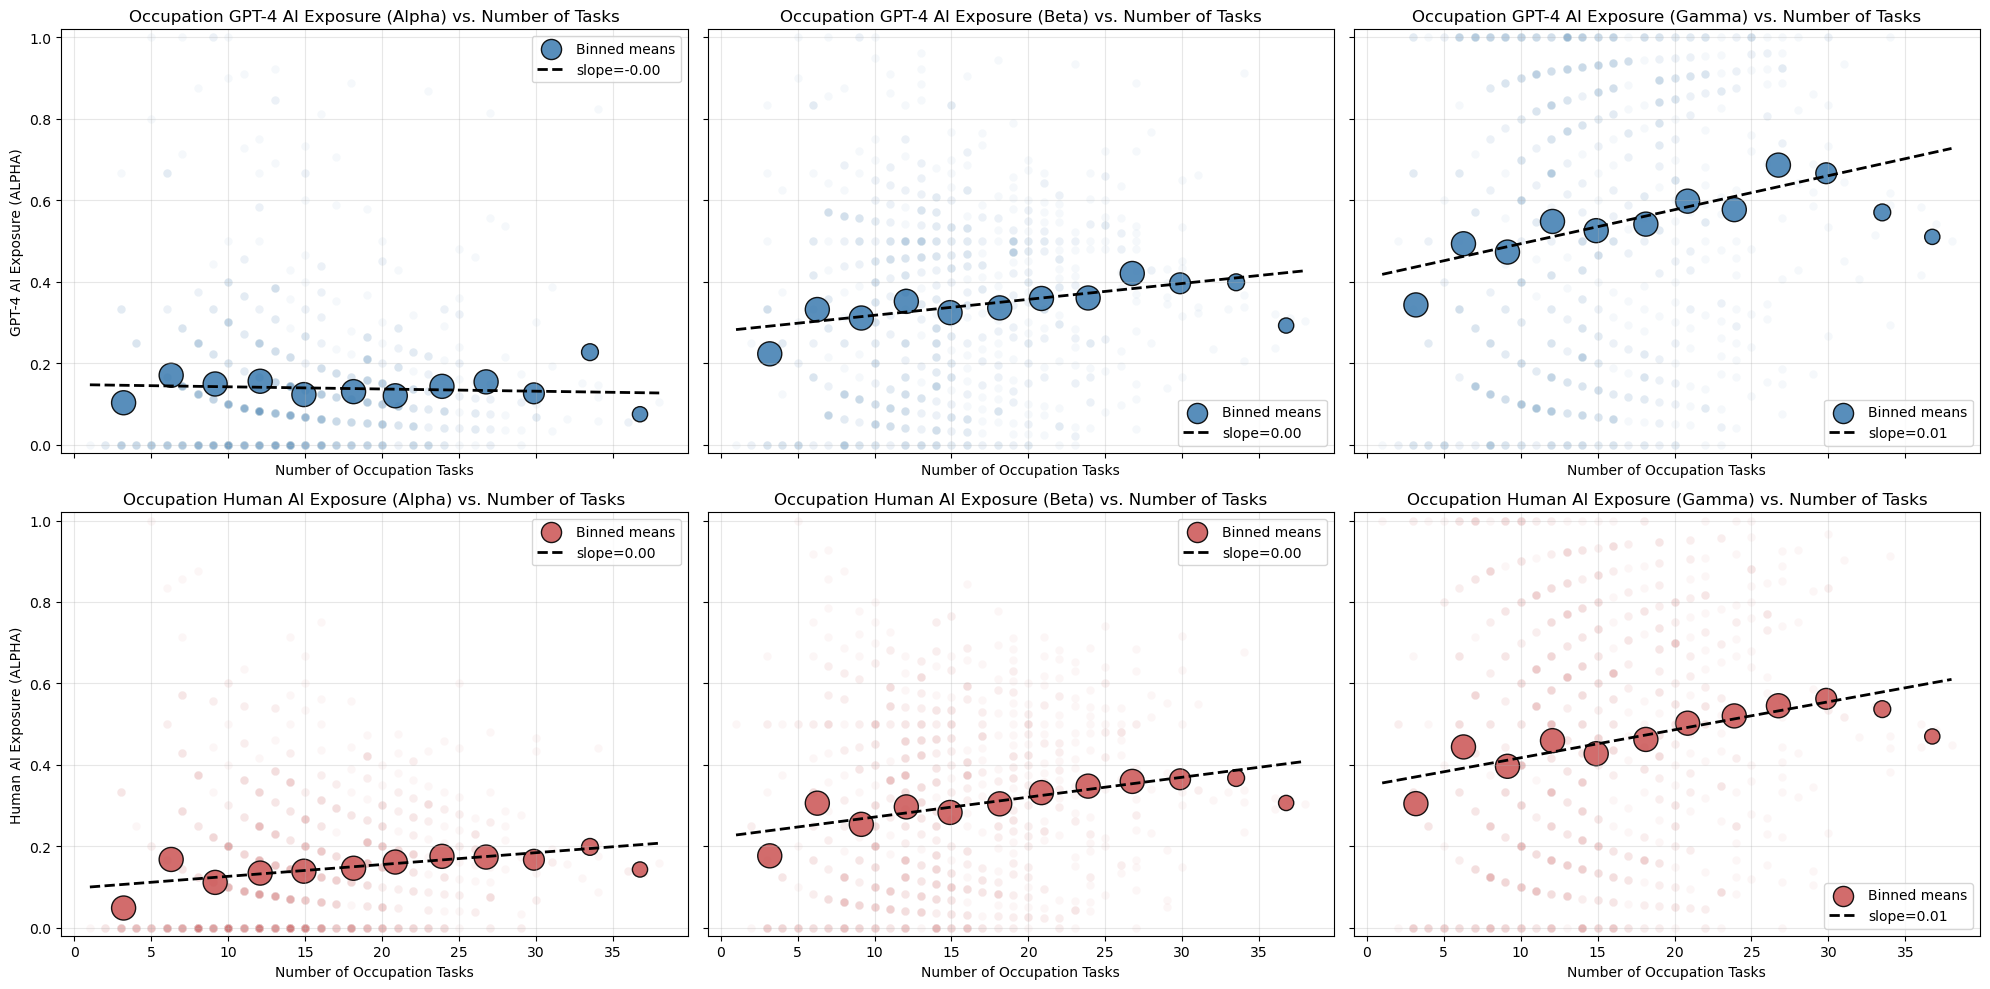

✓ Saved combined 2x3 scatter figure to: ../writeup/plots/taskCounts_aiExposure/numtasks_vs_exposure_occupation.png


In [58]:
# Define exposure measures and labels
measures = ['alpha', 'beta', 'gamma']
import numpy as _np

# Create combined 2x3 figure (2 rows: GPT-4, Human; 3 columns: alpha,beta,gamma)
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex='col', sharey='row')
# Top row: GPT-4
for i, measure in enumerate(measures):
    ax = axes[0, i]
    # Plot Number of Occupation Tasks on x and Exposure on y (axes flipped)
    x = exposure_scores_occupation['num_unique_tasks'].astype(float)
    y = exposure_scores_occupation[f'gpt4_{measure}'].astype(float)
    ax.scatter(x, y, alpha=0.05, color='steelblue', edgecolors='white')

    # Add binned scatter overlay: bin by num_unique_tasks
    n_bins = 12
    try:
        bins = pd.cut(x, bins=n_bins)
    except Exception:
        bins = pd.qcut(x, q=min(n_bins, x.nunique()), duplicates='drop')
    bin_stats = (
        exposure_scores_occupation
        .assign(bin=bins)
        .groupby('bin')
        .agg(task_count_mean=('num_unique_tasks', 'mean'),
             exposure_mean=(f'gpt4_{measure}', 'mean'),
             count=('num_unique_tasks', 'size'))
        .reset_index()
    )
    base_marker_scale = 60
    bin_marker_sizes = np.clip(np.sqrt(bin_stats['count']) * base_marker_scale, 20, 300)
    ax.scatter(bin_stats['task_count_mean'], bin_stats['exposure_mean'], s=bin_marker_sizes, color='steelblue', alpha=0.9, edgecolors='k', label='Binned means')

    # Fit linear regression line if we have enough valid points
    valid_mask = (~_np.isnan(x)) & (~_np.isnan(y))
    if valid_mask.sum() > 1:
        # Fit regression line with x=num_tasks, y=exposure
        coeffs = _np.polyfit(x[valid_mask], y[valid_mask], 1)
        x_fit = _np.linspace(x[valid_mask].min(), x[valid_mask].max(), 100)
        y_fit = coeffs[0] * x_fit + coeffs[1]
        # Use two decimal places for slope
        ax.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=f'slope={coeffs[0]:.2f}')
        ax.legend()
    # xlabel is number of tasks, ylabel is exposure (flipped)
    ax.set_xlabel('Number of Occupation Tasks')
    if i == 0:
        ax.set_ylabel(f'GPT-4 AI Exposure ({measure.upper()})')
    ax.set_title(f'Occupation GPT-4 AI Exposure ({measure.capitalize()}) vs. Number of Tasks')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.02, 1.02)

# Bottom row: Human
for i, measure in enumerate(measures):
    ax = axes[1, i]
    # Plot Number of Occupation Tasks on x and Exposure on y (axes flipped)
    x = exposure_scores_occupation['num_unique_tasks'].astype(float)
    y = exposure_scores_occupation[f'human_{measure}'].astype(float)
    ax.scatter(x, y, alpha=0.05, color='indianred', edgecolors='white')

    # Binned overlay
    n_bins = 12
    try:
        bins = pd.cut(x, bins=n_bins)
    except Exception:
        bins = pd.qcut(x, q=min(n_bins, x.nunique()), duplicates='drop')
    bin_stats = (
        exposure_scores_occupation
        .assign(bin=bins)
        .groupby('bin')
        .agg(task_count_mean=('num_unique_tasks', 'mean'),
             exposure_mean=(f'human_{measure}', 'mean'),
             count=('num_unique_tasks', 'size'))
        .reset_index()
    )
    base_marker_scale = 60
    bin_marker_sizes = np.clip(np.sqrt(bin_stats['count']) * base_marker_scale, 20, 300)
    ax.scatter(bin_stats['task_count_mean'], bin_stats['exposure_mean'], s=bin_marker_sizes, color='indianred', alpha=0.9, edgecolors='k', label='Binned means')

    # Fit linear regression line if we have enough valid points
    valid_mask = (~_np.isnan(x)) & (~_np.isnan(y))
    if valid_mask.sum() > 1:
        coeffs = _np.polyfit(x[valid_mask], y[valid_mask], 1)
        x_fit = _np.linspace(x[valid_mask].min(), x[valid_mask].max(), 100)
        y_fit = coeffs[0] * x_fit + coeffs[1]
        # Use two decimal places for slope
        ax.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=f'slope={coeffs[0]:.2f}')
        ax.legend()
    ax.set_xlabel('Number of Occupation Tasks')
    if i == 0:
        ax.set_ylabel(f'Human AI Exposure ({measure.upper()})')
    ax.set_title(f'Occupation Human AI Exposure ({measure.capitalize()}) vs. Number of Tasks')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.02, 1.02)

plt.tight_layout()
os.makedirs(f'{output_plot_path}/taskCounts_aiExposure', exist_ok=True)
combined_plot_file = f'{output_plot_path}/taskCounts_aiExposure/numtasks_vs_exposure_occupation.png'
plt.savefig(combined_plot_file, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved combined 2x3 scatter figure to: {combined_plot_file}")

## Use Occupation-level AI Exposure Measures to Calculate Industry Group-level Exposure Levels

In [59]:
# Create and save industry group-level exposure datasets (Major, Minor, Broad, Detailed)
import os
print('Creating industry group-level exposure datasets and saving to data/industryGroup_exposure')
group_levels = [
    ('Major_Group_Code', 'Major_Group_Title'),
    ('Minor_Group_Code', 'Minor_Group_Title'),
    ('Broad_Occupation_Code', 'Broad_Occupation_Title'),
    ('Detailed_Occupation_Code', 'Detailed_Occupation_Title')
]
exposure_cols = [
    'gpt4_alpha', 'gpt4_beta', 'gpt4_gamma',
    'human_alpha', 'human_beta', 'human_gamma'
]
output_dir = f'{output_data_path}/taskCounts_aiExposure/industryGroup_exposure'
os.makedirs(output_dir, exist_ok=True)
for code_col, title_col in group_levels:
    # Build occupation-level mapping and ensure num_unique_tasks present
    # exposure_scores_occupation already contains num_unique_tasks and ONET hierarchy columns
    agg_funcs = {col: 'mean' for col in exposure_cols}
    agg_funcs.update({'O*NET-SOC Code': 'nunique', 'num_unique_tasks': 'sum'})
    group_df = exposure_scores_occupation.groupby([code_col, title_col]).agg(agg_funcs).reset_index()
    group_df = group_df.rename(columns={'O*NET-SOC Code': 'num_unique_occupations'})
    # Save dataset to data folder
    out_file = f'{output_dir}/{code_col}_exposure.csv'
    group_df.to_csv(out_file, index=False)
    print(f'✓ Saved {code_col} exposure dataset to: {out_file}')
    display(group_df.head())

Creating industry group-level exposure datasets and saving to data/industryGroup_exposure
✓ Saved Major_Group_Code exposure dataset to: ../data/computed_objects/taskCounts_aiExposure/industryGroup_exposure/Major_Group_Code_exposure.csv


,Major_Group_Code,Major_Group_Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma,num_unique_occupations,num_unique_tasks
0,11-0000,Management Occupations,0.07,0.47,0.86,0.18,0.43,0.68,50,843
1,13-0000,Business and Financial Operations Occupations,0.16,0.54,0.93,0.28,0.53,0.79,43,675
2,15-0000,Computer and Mathematical Occupations,0.50,0.74,0.97,0.30,0.60,0.91,29,547
3,17-0000,Architecture and Engineering Occupations,0.17,0.50,0.84,0.20,0.44,0.68,55,903
4,19-0000,"Life, Physical, and Social Science Occupations",0.13,0.47,0.80,0.29,0.50,0.71,57,869


✓ Saved Minor_Group_Code exposure dataset to: ../data/computed_objects/taskCounts_aiExposure/industryGroup_exposure/Minor_Group_Code_exposure.csv


,Minor_Group_Code,Minor_Group_Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma,num_unique_occupations,num_unique_tasks
0,11-1000,Top Executives,0.09,0.51,0.93,0.13,0.38,0.64,3,46
1,11-2000,"Advertising, Marketing, Promotions, Public Rel...",0.03,0.49,0.95,0.21,0.54,0.87,3,38
2,11-3000,Operations Specialties Managers,0.06,0.45,0.85,0.15,0.41,0.66,14,220
3,11-9000,Other Management Occupations,0.06,0.43,0.80,0.19,0.40,0.61,10,170
4,13-1000,Business Operations Specialists,0.15,0.52,0.89,0.26,0.47,0.69,20,302


✓ Saved Broad_Occupation_Code exposure dataset to: ../data/computed_objects/taskCounts_aiExposure/industryGroup_exposure/Broad_Occupation_Code_exposure.csv


,Broad_Occupation_Code,Broad_Occupation_Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma,num_unique_occupations,num_unique_tasks
0,11-1010,Chief Executives,0.14,0.51,0.89,0.13,0.38,0.62,2,37
1,11-1020,General and Operations Managers,0.00,0.50,1.00,0.11,0.39,0.67,1,9
2,11-2010,Advertising and Promotions Managers,0.00,0.50,1.00,0.38,0.62,0.85,1,13
3,11-2020,Marketing and Sales Managers,0.04,0.48,0.92,0.12,0.50,0.88,2,25
4,11-3010,Administrative Services and Facilities Managers,0.00,0.30,0.60,0.20,0.50,0.80,1,5


✓ Saved Detailed_Occupation_Code exposure dataset to: ../data/computed_objects/taskCounts_aiExposure/industryGroup_exposure/Detailed_Occupation_Code_exposure.csv


,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_alpha,gpt4_beta,gpt4_gamma,human_alpha,human_beta,human_gamma,num_unique_occupations,num_unique_tasks
0,11-1011,Chief Executives,0.14,0.51,0.89,0.13,0.38,0.62,2,37
1,11-1021,General and Operations Managers,0.00,0.50,1.00,0.11,0.39,0.67,1,9
2,11-2011,Advertising and Promotions Managers,0.00,0.50,1.00,0.38,0.62,0.85,1,13
3,11-2021,Marketing Managers,0.08,0.50,0.92,0.17,0.54,0.92,1,12
4,11-2022,Sales Managers,0.00,0.46,0.92,0.08,0.46,0.85,1,13


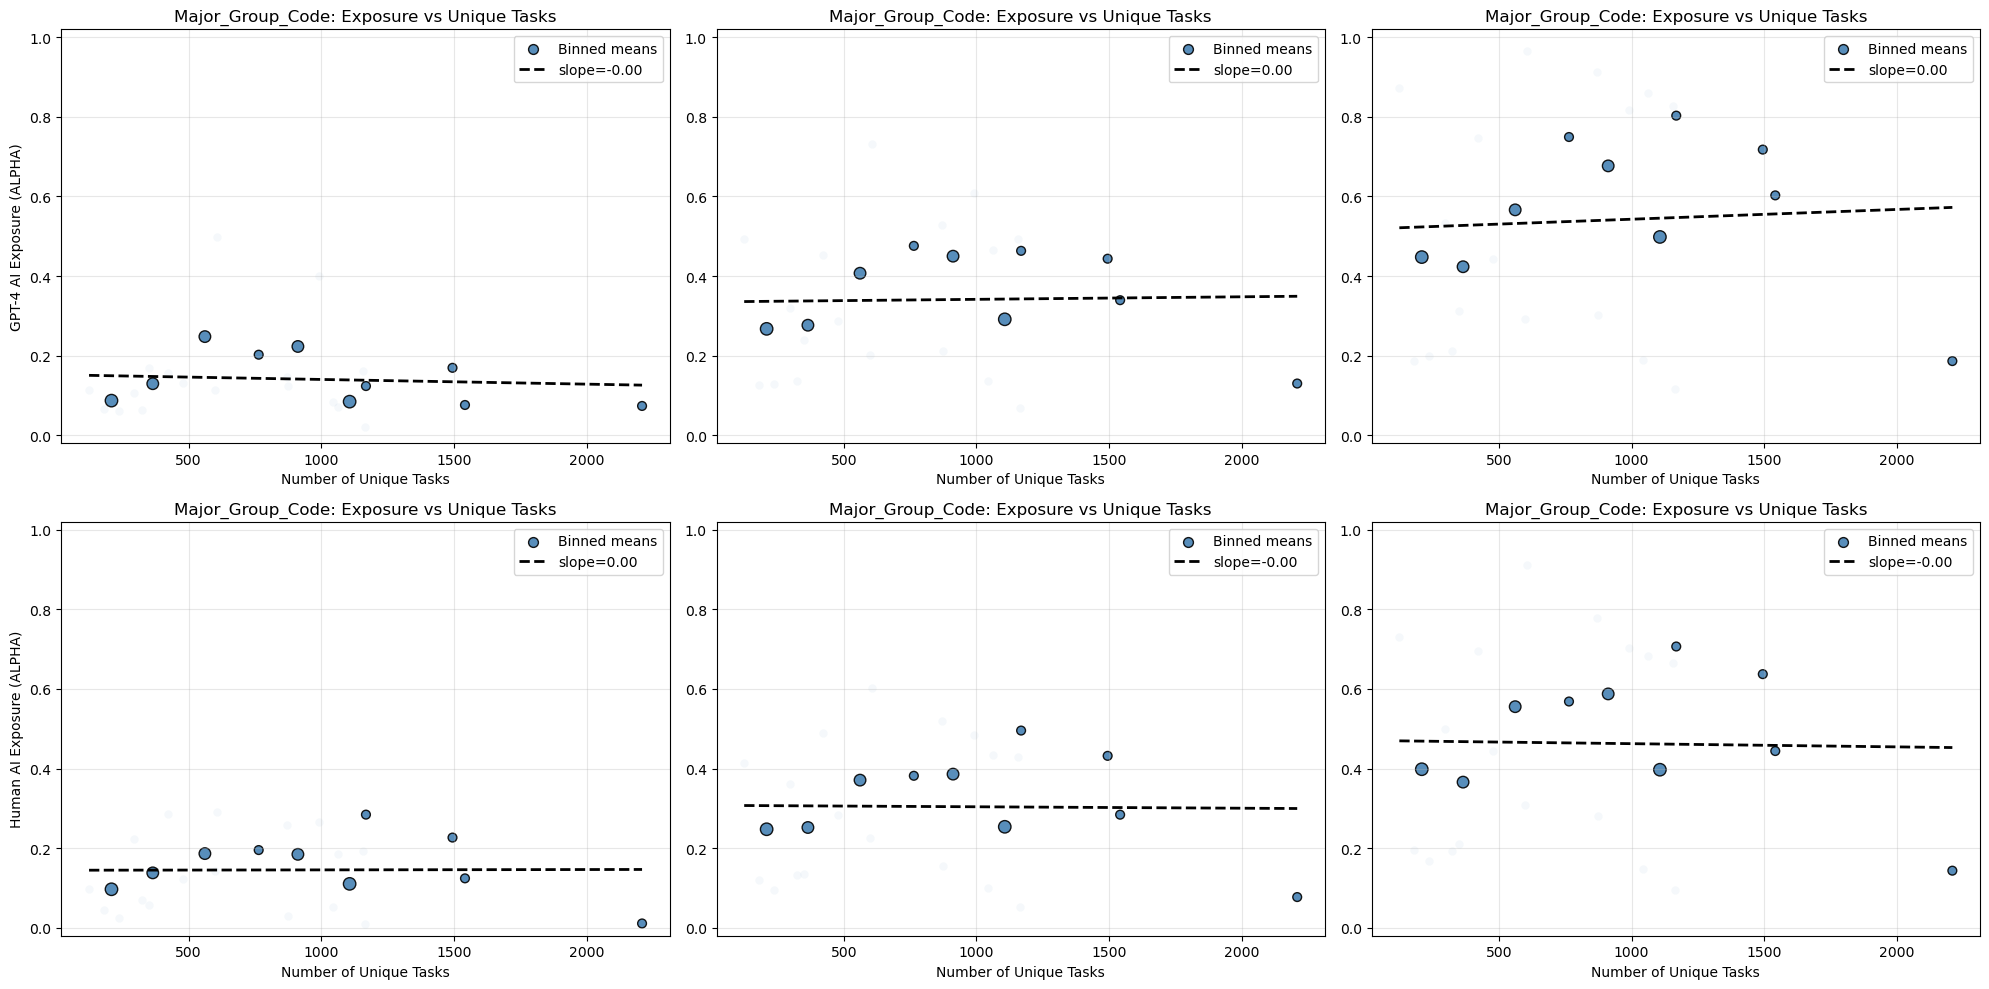

✓ Saved Major_Group_Code exposure vs tasks plot to: ../writeup/plots/taskCounts_aiExposure/industryGroup_exposure/tasks_vs_exposure_Major_Group_Code.png


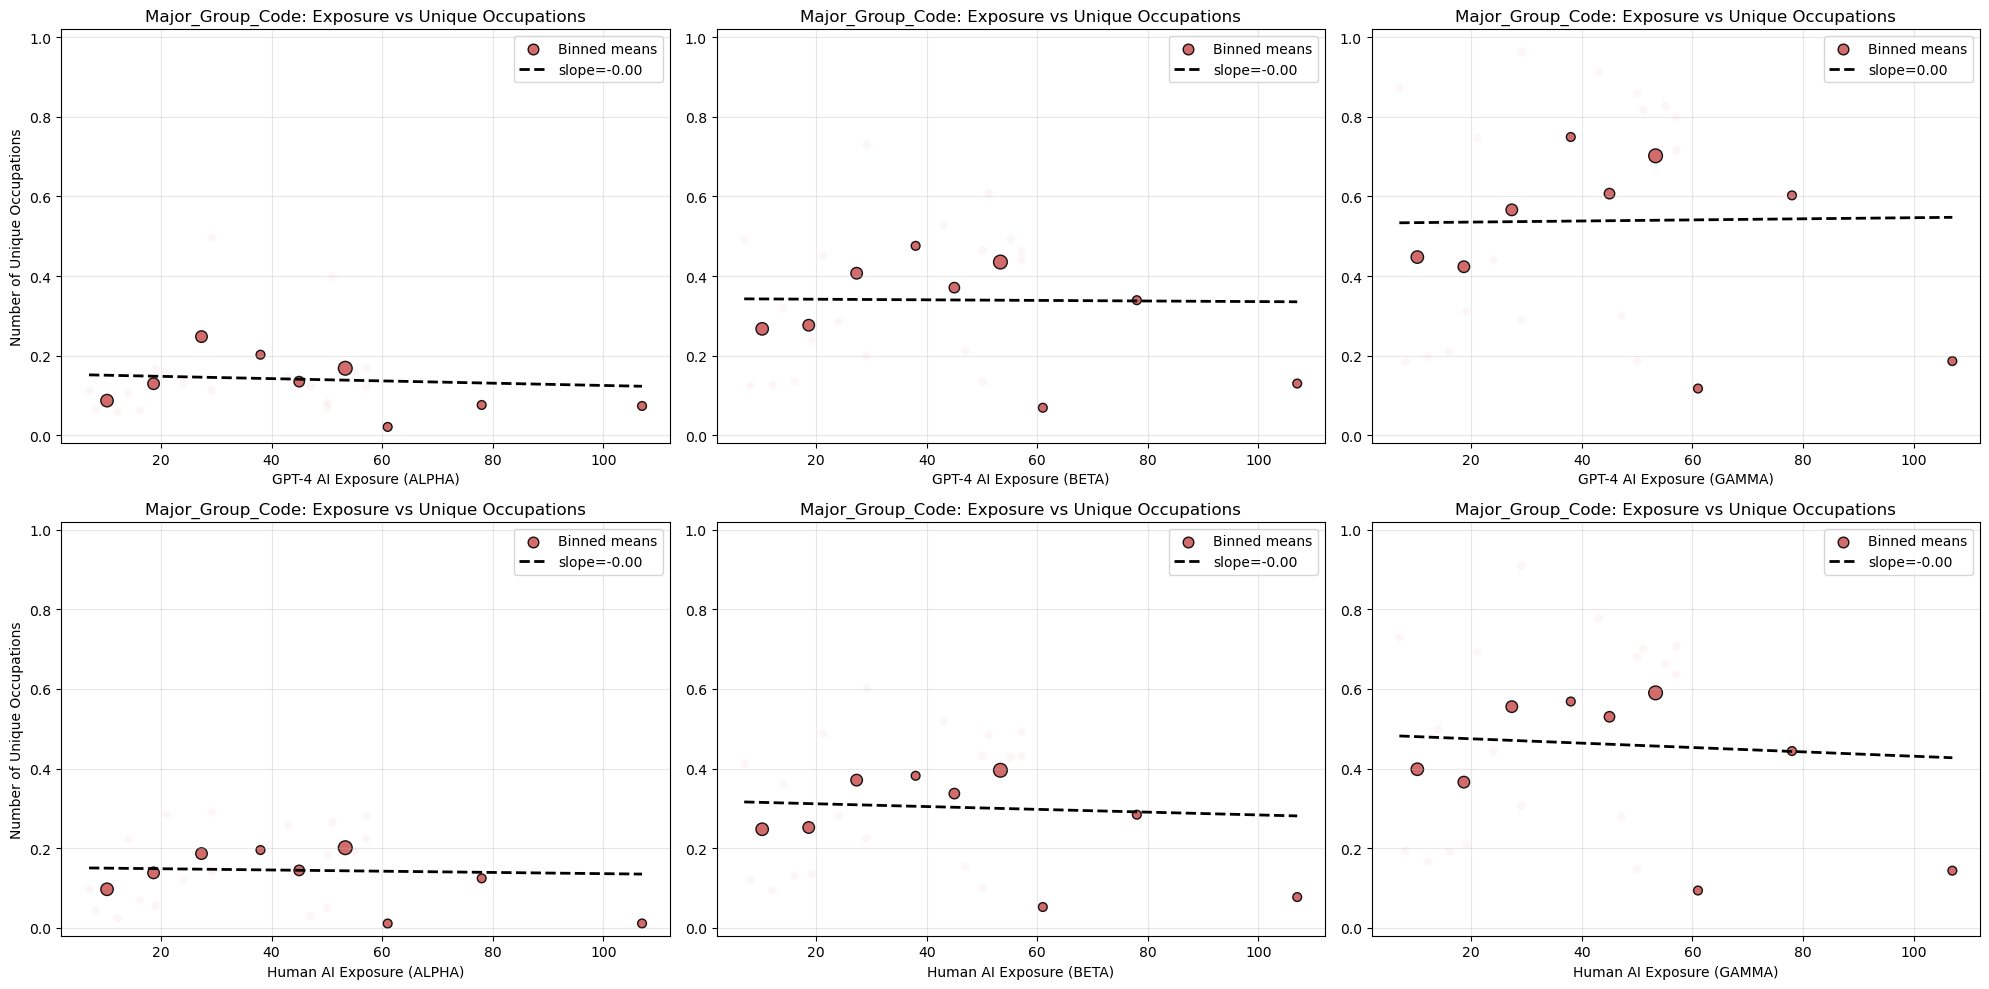

✓ Saved Major_Group_Code exposure vs occupations plot to: ../writeup/plots/taskCounts_aiExposure/industryGroup_exposure/occupations_vs_exposure_Major_Group_Code.png


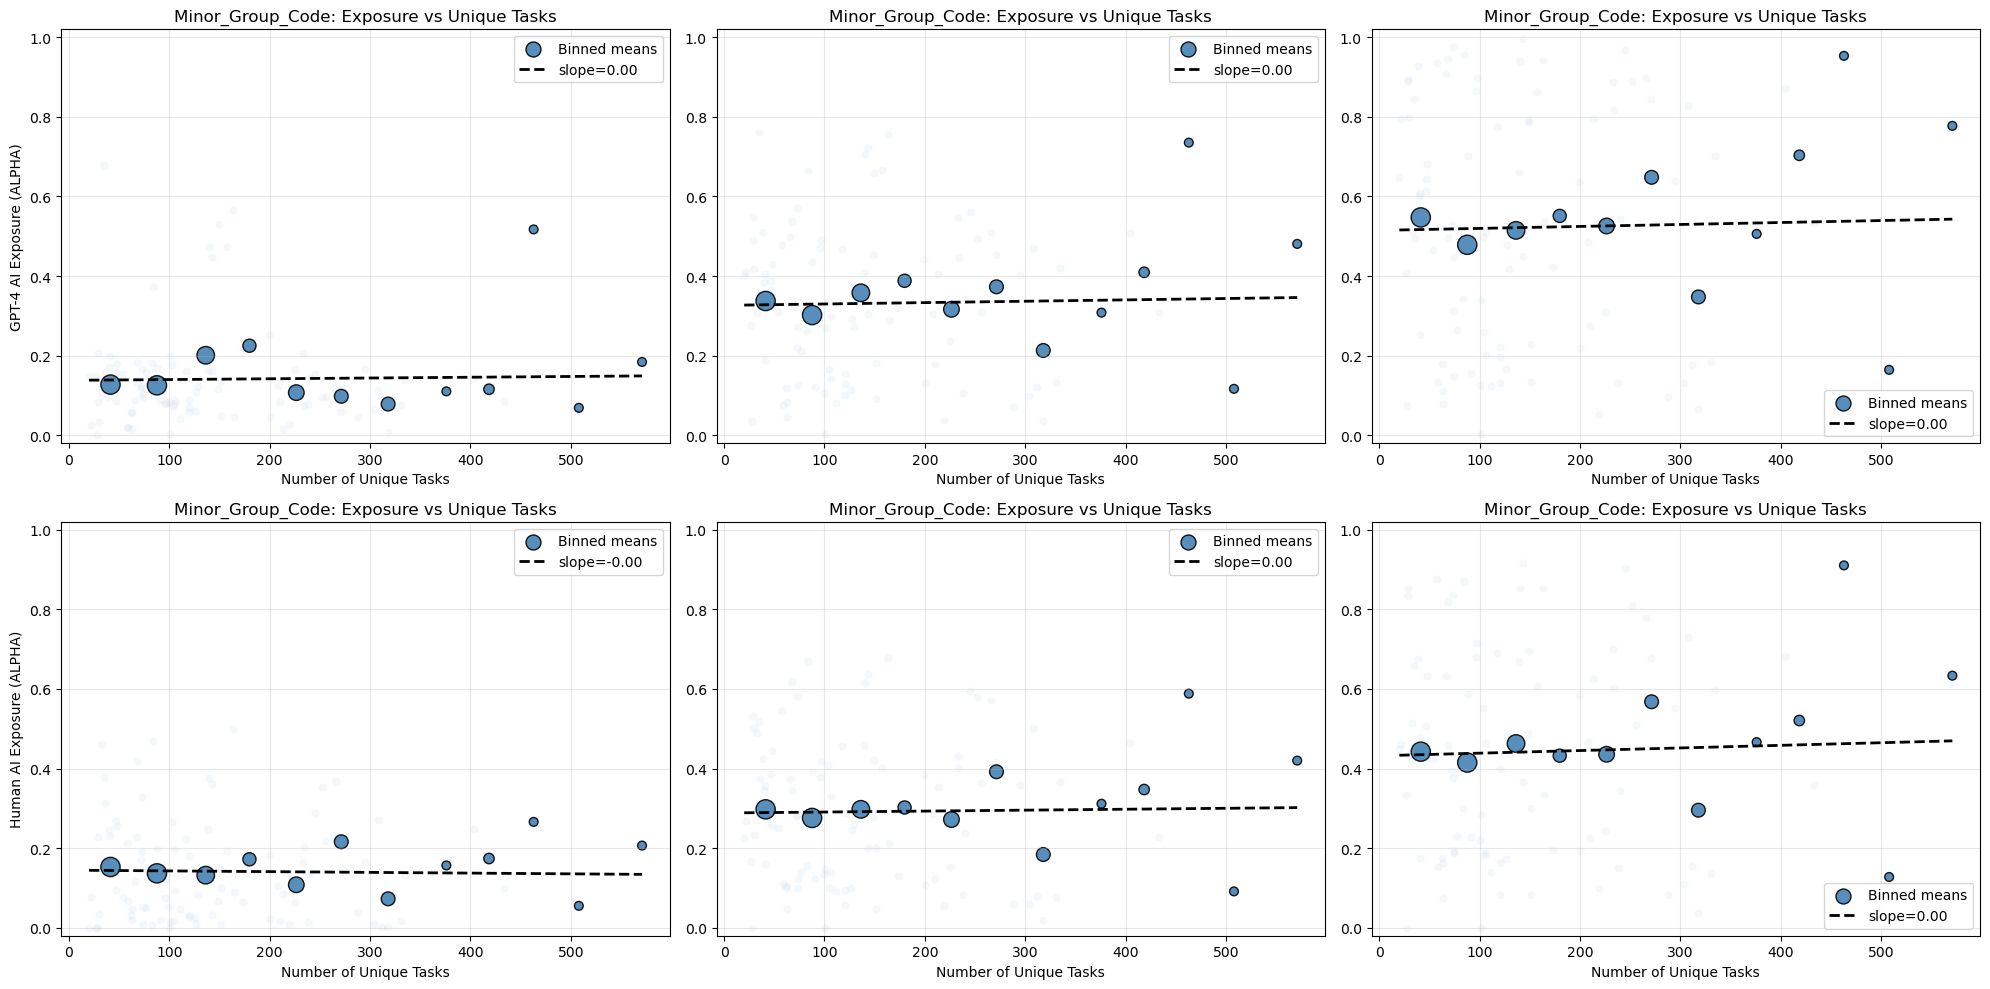

✓ Saved Minor_Group_Code exposure vs tasks plot to: ../writeup/plots/taskCounts_aiExposure/industryGroup_exposure/tasks_vs_exposure_Minor_Group_Code.png


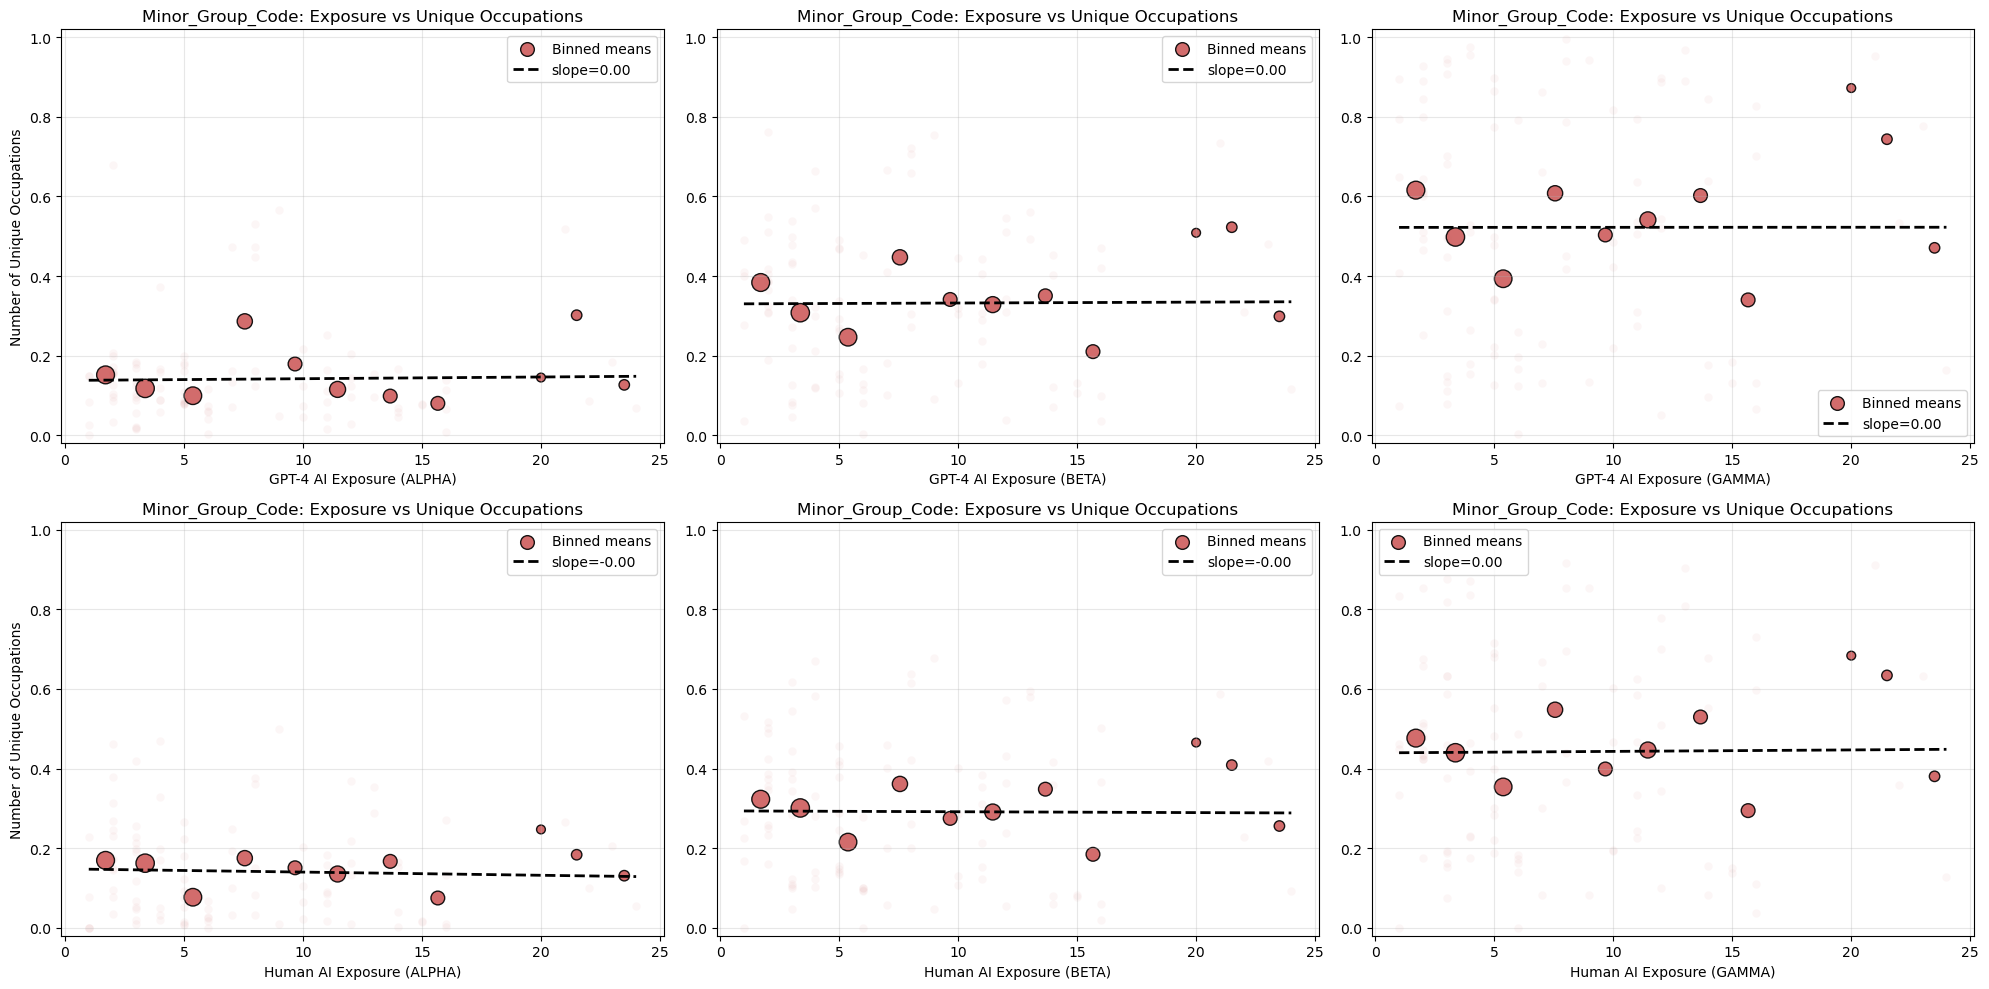

✓ Saved Minor_Group_Code exposure vs occupations plot to: ../writeup/plots/taskCounts_aiExposure/industryGroup_exposure/occupations_vs_exposure_Minor_Group_Code.png


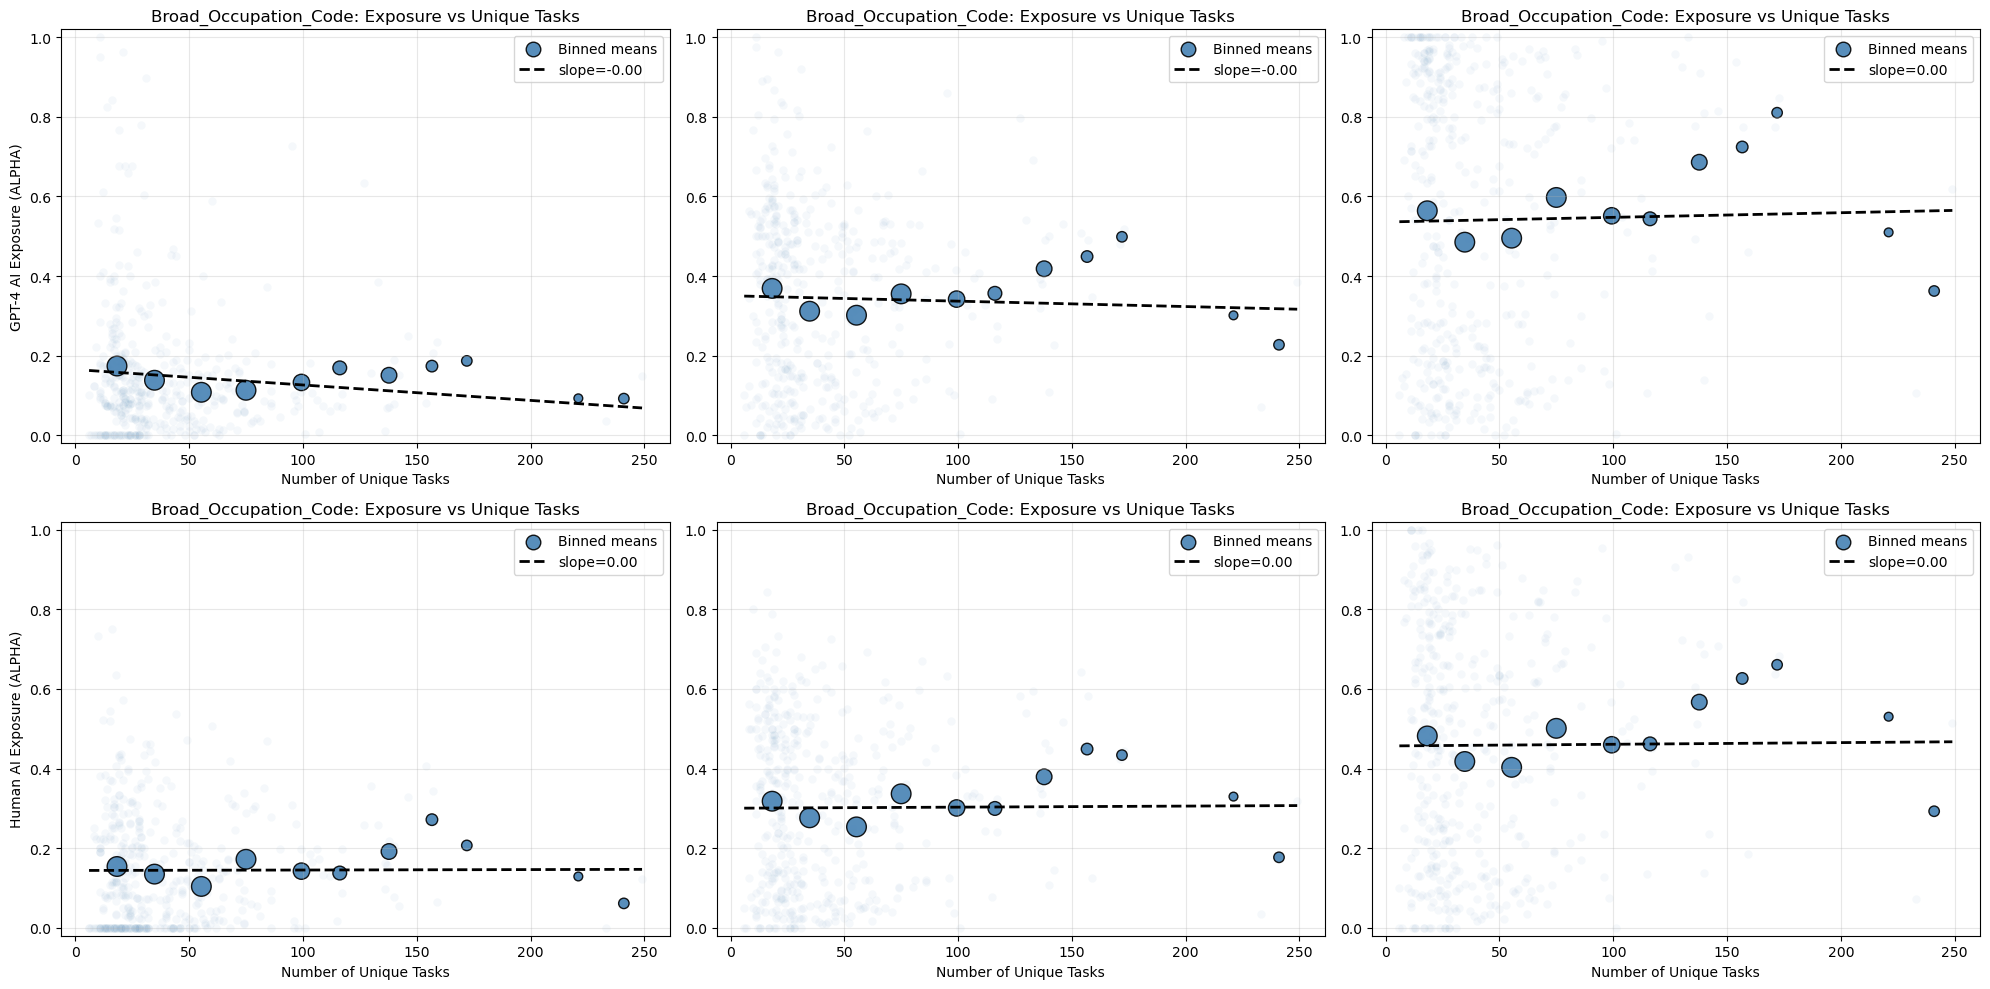

✓ Saved Broad_Occupation_Code exposure vs tasks plot to: ../writeup/plots/taskCounts_aiExposure/industryGroup_exposure/tasks_vs_exposure_Broad_Occupation_Code.png


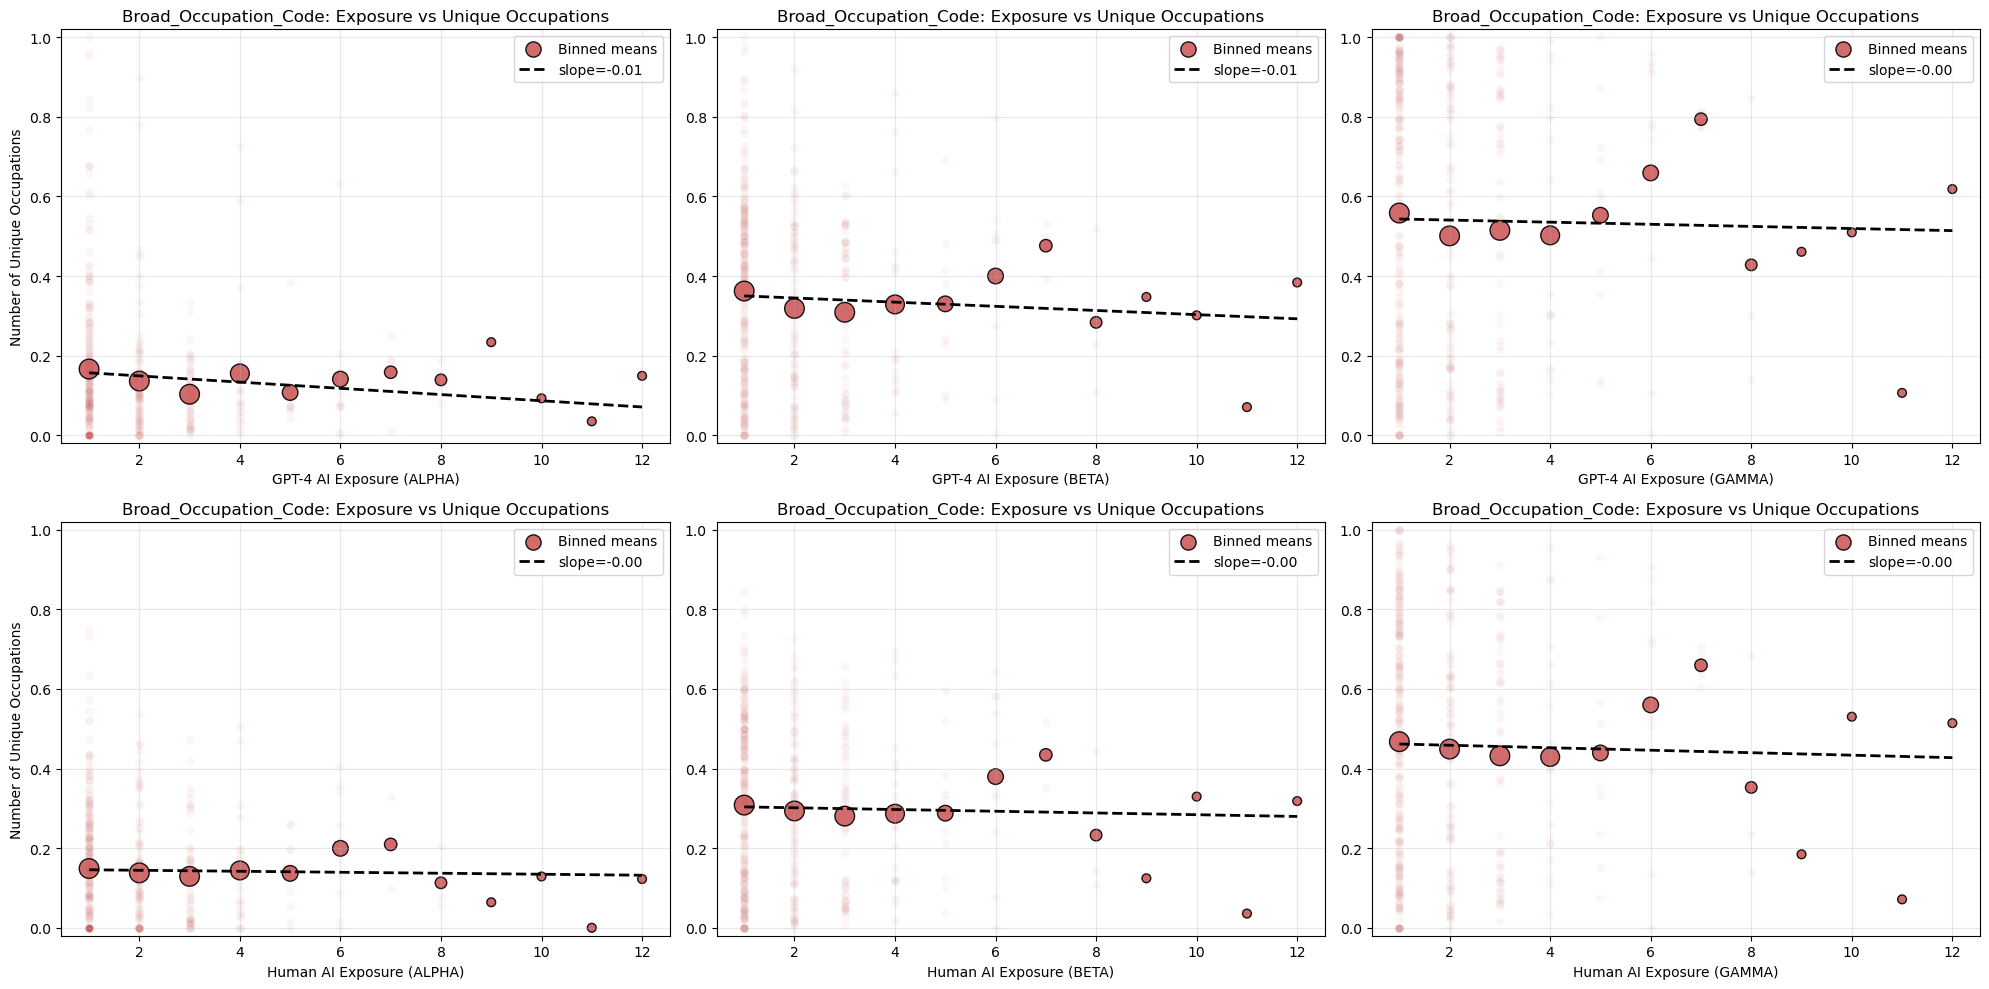

✓ Saved Broad_Occupation_Code exposure vs occupations plot to: ../writeup/plots/taskCounts_aiExposure/industryGroup_exposure/occupations_vs_exposure_Broad_Occupation_Code.png


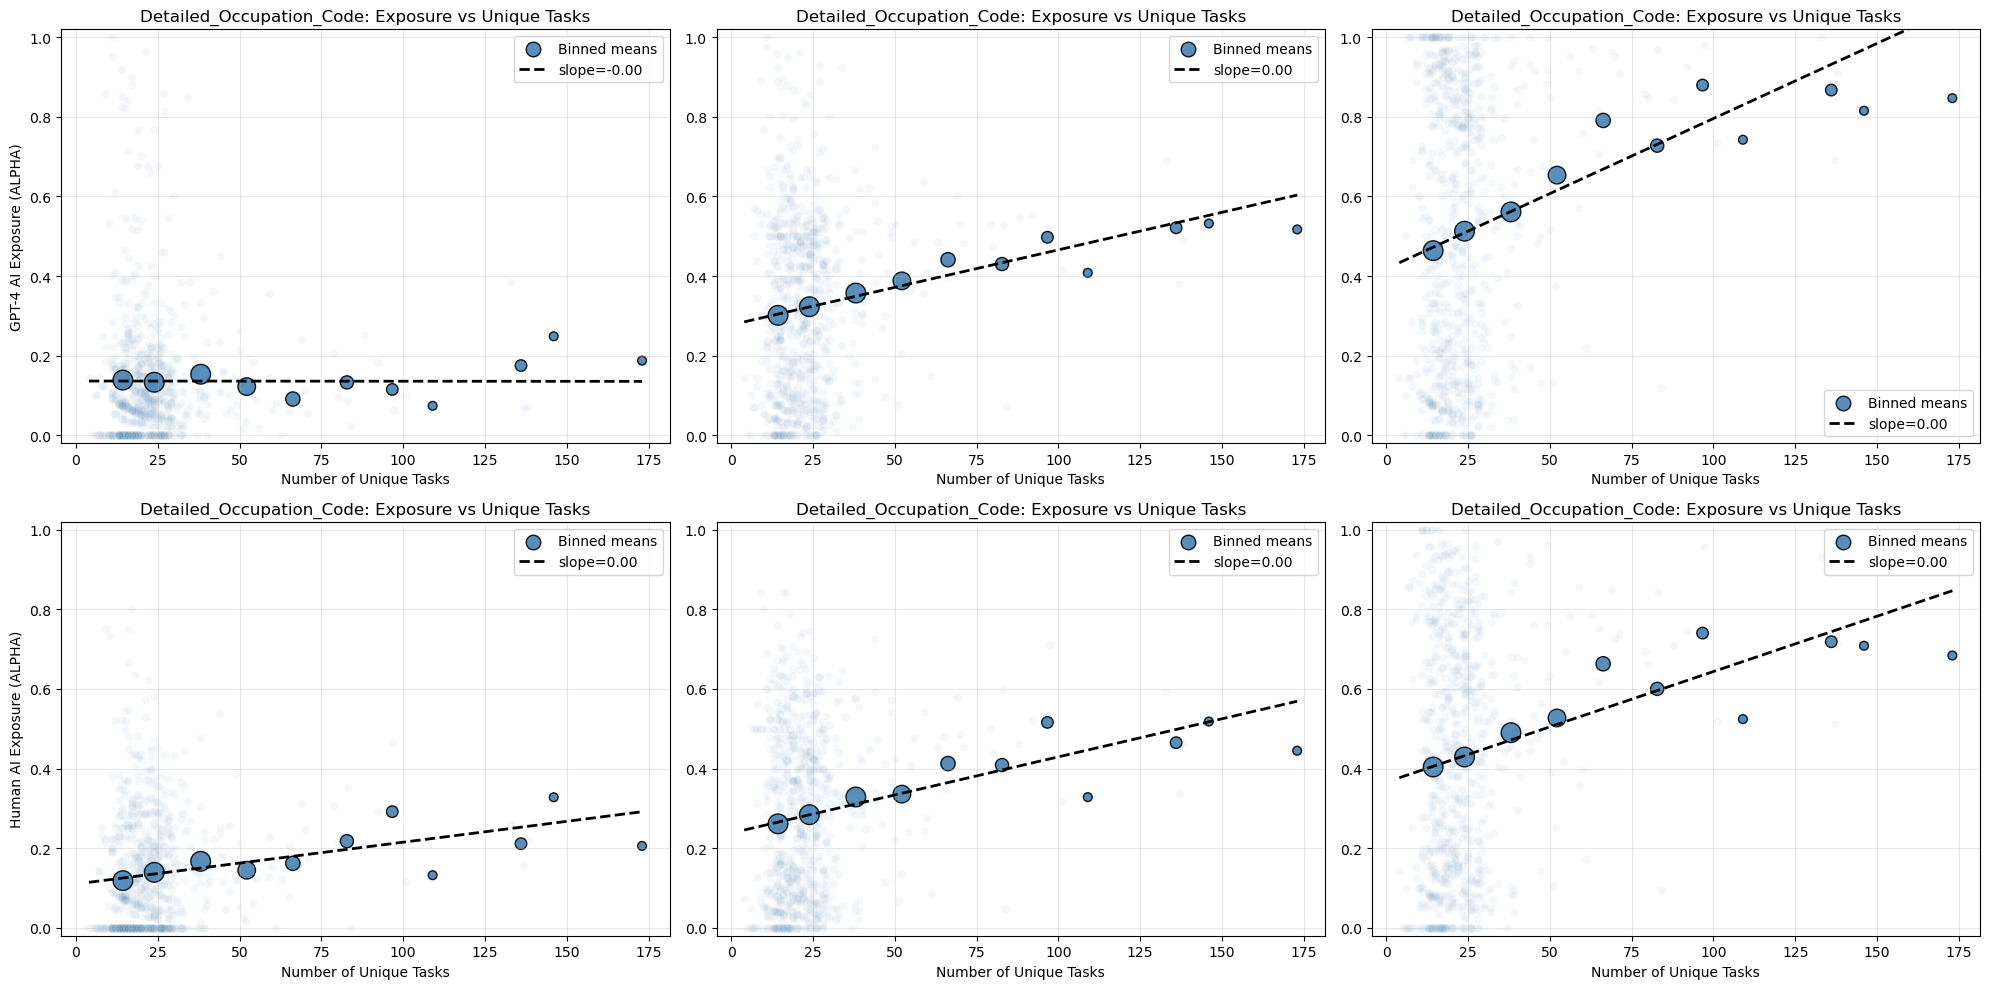

✓ Saved Detailed_Occupation_Code exposure vs tasks plot to: ../writeup/plots/taskCounts_aiExposure/industryGroup_exposure/tasks_vs_exposure_Detailed_Occupation_Code.png


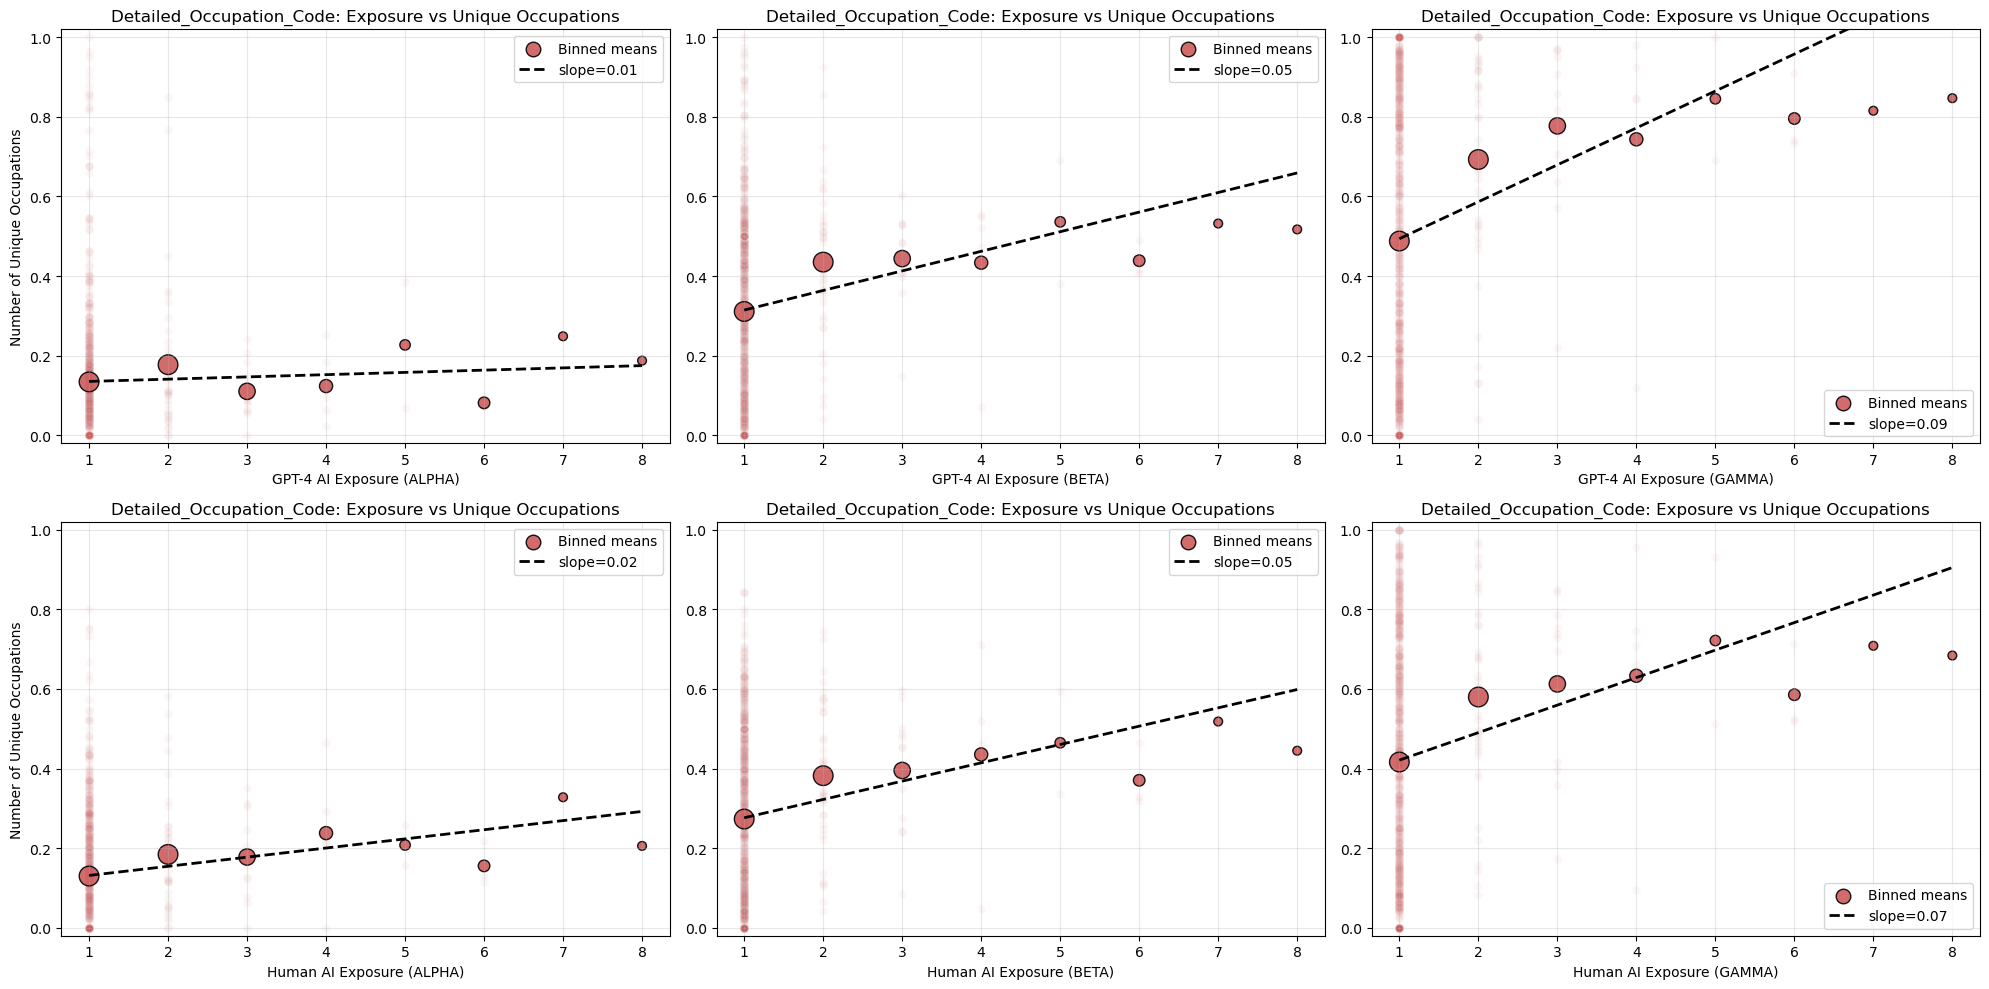

✓ Saved Detailed_Occupation_Code exposure vs occupations plot to: ../writeup/plots/taskCounts_aiExposure/industryGroup_exposure/occupations_vs_exposure_Detailed_Occupation_Code.png


In [60]:
# Plot 2x3 figures for each industry group: exposure vs unique tasks, and exposure vs unique occupations
import matplotlib.pyplot as plt
import numpy as np
group_levels = [
    ('Major_Group_Code', 'Major_Group_Title'),
    ('Minor_Group_Code', 'Minor_Group_Title'),
    ('Broad_Occupation_Code', 'Broad_Occupation_Title'),
    ('Detailed_Occupation_Code', 'Detailed_Occupation_Title')
]
exposure_cols = [
    'gpt4_alpha', 'gpt4_beta', 'gpt4_gamma',
    'human_alpha', 'human_beta', 'human_gamma'
]
# Create mapping for cleaner labels
exposure_labels = {
    'gpt4_alpha': 'GPT-4 AI Exposure (ALPHA)',
    'gpt4_beta': 'GPT-4 AI Exposure (BETA)',
    'gpt4_gamma': 'GPT-4 AI Exposure (GAMMA)',
    'human_alpha': 'Human AI Exposure (ALPHA)',
    'human_beta': 'Human AI Exposure (BETA)',
    'human_gamma': 'Human AI Exposure (GAMMA)'
}

input_dir = f'{output_data_path}/industryGroup_exposure'
output_dir = f'{output_plot_path}/taskCounts_aiExposure/industryGroup_exposure'
os.makedirs(output_dir, exist_ok=True)
for code_col, title_col in group_levels:
    df = pd.read_csv(f'{input_dir}/{code_col}_exposure.csv')
    # 2x3: exposure vs num_unique_tasks -> now plot tasks on x, exposure on y
    fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=False, sharey=False)
    for i, col in enumerate(exposure_cols):
        ax = axes[i//3, i%3]
        x = df['num_unique_tasks'].astype(float)
        y = df[col].astype(float)
        ax.scatter(x, y, alpha=0.05, color='steelblue', edgecolors='white')
        # Binned overlay
        n_bins = 12
        try:
            bins = pd.cut(x, bins=n_bins)
        except Exception:
            bins = pd.qcut(x, q=min(n_bins, x.nunique()), duplicates='drop')
        bin_stats = (
            df
            .assign(bin=bins)
            .groupby('bin')
            .agg(task_count_mean=('num_unique_tasks', 'mean'),
                 exposure_mean=(col, 'mean'),
                 count=('num_unique_tasks', 'size'))
            .reset_index()
        )
        base_marker_scale = 40
        bin_marker_sizes = np.clip(np.sqrt(bin_stats['count']) * base_marker_scale, 20, 200)
        ax.scatter(bin_stats['task_count_mean'], bin_stats['exposure_mean'], s=bin_marker_sizes, color='steelblue', alpha=0.9, edgecolors='k', label='Binned means')

        valid_mask = (~np.isnan(x)) & (~np.isnan(y))
        if valid_mask.sum() > 1:
            coeffs = np.polyfit(x[valid_mask], y[valid_mask], 1)
            x_fit = np.linspace(x[valid_mask].min(), x[valid_mask].max(), 100)
            y_fit = coeffs[0] * x_fit + coeffs[1]
            ax.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=f'slope={coeffs[0]:.2f}')
            ax.legend()
        ax.set_xlabel('Number of Unique Tasks')
        if i % 3 == 0:
            ax.set_ylabel(exposure_labels[col])
        ax.set_title(f'{code_col}: Exposure vs Unique Tasks')
        ax.grid(True, alpha=0.3)
        # Ensure y-axis range covers 0..1 with a small margin for visualization (exposure axis)
        ax.set_ylim(-0.02, 1.02)
    plt.tight_layout()
    plot_file = f'{output_dir}/tasks_vs_exposure_{code_col}.png'
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'✓ Saved {code_col} exposure vs tasks plot to: {plot_file}')
    # 2x3: exposure vs num_unique_occupations -> now plot occupations on x, exposure on y
    fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=False, sharey=False)
    for i, col in enumerate(exposure_cols):
        ax = axes[i//3, i%3]
        x = df['num_unique_occupations'].astype(float)
        y = df[col].astype(float)
        ax.scatter(x, y, alpha=0.05, color='indianred', edgecolors='white')

        # Binned overlay
        n_bins = 12
        try:
            bins = pd.cut(x, bins=n_bins)
        except Exception:
            bins = pd.qcut(x, q=min(n_bins, x.nunique()), duplicates='drop')
        bin_stats = (
            df
            .assign(bin=bins)
            .groupby('bin')
            .agg(task_count_mean=('num_unique_occupations', 'mean'),
                 exposure_mean=(col, 'mean'),
                 count=('num_unique_occupations', 'size'))
            .reset_index()
        )
        bin_marker_sizes = np.clip(np.sqrt(bin_stats['count']) * base_marker_scale, 20, 200)
        ax.scatter(bin_stats['task_count_mean'], bin_stats['exposure_mean'], s=bin_marker_sizes, color='indianred', alpha=0.9, edgecolors='k', label='Binned means')

        valid_mask = (~np.isnan(x)) & (~np.isnan(y))
        if valid_mask.sum() > 1:
            coeffs = np.polyfit(x[valid_mask], y[valid_mask], 1)
            x_fit = np.linspace(x[valid_mask].min(), x[valid_mask].max(), 100)
            y_fit = coeffs[0] * x_fit + coeffs[1]
            ax.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=f'slope={coeffs[0]:.2f}')
            ax.legend()
        ax.set_xlabel(exposure_labels[col])
        if i % 3 == 0:
            ax.set_ylabel('Number of Unique Occupations')
        ax.set_title(f'{code_col}: Exposure vs Unique Occupations')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.02, 1.02)
    plt.tight_layout()
    plot_file = f'{output_dir}/occupations_vs_exposure_{code_col}.png'
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'✓ Saved {code_col} exposure vs occupations plot to: {plot_file}')

### Highlight industries one by one in previous graphs

In [61]:
# Highlight each industry group one-by-one using Major groups as the driver for highlights
# Build a mapping from Major -> { minor: [...], broad: [...], detailed: [...], label: 'Major title' }
# Save plots under: output_plot_path/taskCounts_aiExposure/industryGroup_exposure/industry/<code_col>/
import os
import matplotlib.pyplot as plt
import numpy as np

# Config
group_levels = [
    ('Major_Group_Code', 'Major_Group_Title'),
    ('Minor_Group_Code', 'Minor_Group_Title'),
    ('Broad_Occupation_Code', 'Broad_Occupation_Title'),
    ('Detailed_Occupation_Code', 'Detailed_Occupation_Title')
]
exposure_cols = [
    'gpt4_alpha', 'gpt4_beta', 'gpt4_gamma',
    'human_alpha', 'human_beta', 'human_gamma'
]

# Create mapping for cleaner x-axis labels (keeps consistent style with earlier plots)
exposure_labels = {
    'gpt4_alpha': 'GPT-4 AI Exposure (ALPHA)',
    'gpt4_beta': 'GPT-4 AI Exposure (BETA)',
    'gpt4_gamma': 'GPT-4 AI Exposure (GAMMA)',
    'human_alpha': 'Human AI Exposure (ALPHA)',
    'human_beta': 'Human AI Exposure (BETA)',
    'human_gamma': 'Human AI Exposure (GAMMA)'
}

# Input group-level CSVs (created earlier)
input_dir = f'{output_data_path}/taskCounts_aiExposure/industryGroup_exposure'
# Save into the requested path (with an 'industry' folder)
industry_root = f'{output_plot_path}/taskCounts_aiExposure/industryGroup_exposure/industry'
os.makedirs(industry_root, exist_ok=True)

# Helper to sanitize filenames
def _safe_name(s):
    return str(s).replace('/', '_').replace(' ', '_')

# Highlight color (yellow-ish)
highlight_color = '#FFD966'  # warm yellow

# Build mapping from the detailed occupation-level dataset (exposure_scores_occupation) if present
major_mapping = {}
if 'exposure_scores_occupation' in globals():
    df_occ = exposure_scores_occupation.copy()
    if 'Major_Group_Code' in df_occ.columns:
        for maj, g in df_occ.groupby('Major_Group_Code'):
            # capture an authoritative Major title when available
            maj_titles = g['Major_Group_Title'].dropna().unique().tolist() if 'Major_Group_Title' in g.columns else []
            major_mapping[maj] = {
                'minor': g['Minor_Group_Code'].dropna().unique().tolist() if 'Minor_Group_Code' in g.columns else [],
                'broad': g['Broad_Occupation_Code'].dropna().unique().tolist() if 'Broad_Occupation_Code' in g.columns else [],
                'detailed': g['Detailed_Occupation_Code'].dropna().unique().tolist() if 'Detailed_Occupation_Code' in g.columns else [],
                'label': maj_titles[0] if maj_titles else None,
            }
    else:
        print("Warning: 'Major_Group_Code' not present in exposure_scores_occupation; mapping will be empty")
else:
    print("Warning: exposure_scores_occupation not found in the notebook environment; mapping will be empty")

# If mapping is empty, try to build a fallback by scanning all group-level CSVs (best-effort)
if not major_mapping:
    for code_col, title_col in group_levels:
        fp = f'{input_dir}/{code_col}_exposure.csv'
        if not os.path.exists(fp):
            continue
        df = pd.read_csv(fp)
        if 'Major_Group_Code' in df.columns:
            for maj, g in df.groupby('Major_Group_Code'):
                if maj not in major_mapping:
                    major_mapping[maj] = {'minor': [], 'broad': [], 'detailed': [], 'label': None}
                # collect codes present in this file for safety
                if 'Minor_Group_Code' in df.columns:
                    major_mapping[maj]['minor'].extend(g['Minor_Group_Code'].dropna().unique().tolist())
                if 'Broad_Occupation_Code' in df.columns:
                    major_mapping[maj]['broad'].extend(g['Broad_Occupation_Code'].dropna().unique().tolist())
                if 'Detailed_Occupation_Code' in df.columns:
                    major_mapping[maj]['detailed'].extend(g['Detailed_Occupation_Code'].dropna().unique().tolist())
                # capture Major title when present
                if 'Major_Group_Title' in df.columns:
                    titles = g['Major_Group_Title'].dropna().unique().tolist()
                    if titles:
                        major_mapping[maj]['label'] = titles[0]
    # dedupe lists
    for maj in list(major_mapping.keys()):
        for k in ['minor', 'broad', 'detailed']:
            major_mapping[maj][k] = list(dict.fromkeys(major_mapping[maj][k]))

if not major_mapping:
    print('Warning: major_mapping is empty after attempts; highlighting will fallback to Major codes present in each file')

# Now iterate over each group-level file and, for each Major group, highlight the bins at that level that belong to the Major
for code_col, title_col in group_levels:
    fp = f'{input_dir}/{code_col}_exposure.csv'
    if not os.path.exists(fp):
        print(f'Skipping {code_col} (file not found: {fp})')
        continue
    df = pd.read_csv(fp)

    out_dir = os.path.join(industry_root, _safe_name(code_col))
    os.makedirs(out_dir, exist_ok=True)

    # Determine the set of majors to iterate (prefer Majors present in this df; fall back to mapping keys)
    majors_in_df = df['Major_Group_Code'].dropna().unique() if 'Major_Group_Code' in df.columns else []
    majors_to_iter = majors_in_df if len(majors_in_df) > 0 else list(major_mapping.keys())

    for major in majors_to_iter:
        # Build mask of rows in df that should be highlighted for this major
        # If we're in Major level, highlight where code equals major
        if code_col == 'Major_Group_Code':
            maj_mask = df[code_col] == major
        else:
            # For non-major levels, use the precomputed mapping where possible
            maj_map_entry = major_mapping.get(major, {})
            if code_col == 'Minor_Group_Code':
                candidates = maj_map_entry.get('minor', [])
            elif code_col == 'Broad_Occupation_Code':
                candidates = maj_map_entry.get('broad', [])
            elif code_col == 'Detailed_Occupation_Code':
                candidates = maj_map_entry.get('detailed', [])
            else:
                candidates = []
            # If candidates are empty, fall back to matching Major_Group_Code column if present
            if candidates:
                maj_mask = df[code_col].isin(candidates)
            elif 'Major_Group_Code' in df.columns:
                maj_mask = df['Major_Group_Code'] == major
            else:
                maj_mask = pd.Series([False] * len(df))

        # label for the major group (for filenames / titles)
        maj_label = None
        # Prefer an explicit Major_Group_Title column in the current file
        if 'Major_Group_Title' in df.columns and (df['Major_Group_Code'] == major).any():
            maj_label = df.loc[df['Major_Group_Code'] == major, 'Major_Group_Title'].iloc[0]
        # Otherwise use the mapping label if available
        if maj_label is None:
            maj_label = major_mapping.get(major, {}).get('label')
        # Final fallback to the raw major code
        maj_label = maj_label or str(major)

        # Build display title showing both code and title when available
        if str(major) != str(maj_label):
            display_title = f"{major}: {maj_label}"
        else:
            display_title = str(major)

        safe_maj = _safe_name(major)

        # --- Plot: exposure vs num_unique_tasks (original underlay + highlighted bins belonging to this major) ---
        fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=False, sharey=False)
        for i, col in enumerate(exposure_cols):
            ax = axes[i//3, i%3]
            x = df['num_unique_tasks'].astype(float)
            y = df[col].astype(float)

            # Plot all points using the ORIGINAL styling with faint alpha
            ax.scatter(x, y, alpha=0.05, color='steelblue', edgecolors='white', s=35, zorder=1)

            # Add binned overlay
            n_bins = 12
            try:
                bins = pd.cut(x, bins=n_bins)
            except Exception:
                bins = pd.qcut(x, q=min(n_bins, x.nunique()), duplicates='drop')
            bin_stats = (
                df
                .assign(bin=bins)
                .groupby('bin')
                .agg(task_count_mean=('num_unique_tasks', 'mean'),
                     exposure_mean=(col, 'mean'),
                     count=('num_unique_tasks', 'size'))
                .reset_index()
            )
            base_marker_scale = 60
            bin_marker_sizes = np.clip(np.sqrt(bin_stats['count']) * base_marker_scale, 20, 300)
            ax.scatter(bin_stats['task_count_mean'], bin_stats['exposure_mean'], s=bin_marker_sizes, color='steelblue', alpha=0.9, edgecolors='k', label='Binned means')

            # Overlay highlighted group's (major) bins in yellow; this will highlight bins at the current level that belong to the major
            if maj_mask.any():
                # ensure indices align
                ax.scatter(x[maj_mask], y[maj_mask], alpha=0.95, color=highlight_color, edgecolors='black', s=120, zorder=3)

            # regression line for ALL points
            valid_mask = (~np.isnan(x)) & (~np.isnan(y))
            if valid_mask.sum() > 1:
                coeffs = np.polyfit(x[valid_mask], y[valid_mask], 1)
                x_fit = np.linspace(x[valid_mask].min(), x[valid_mask].max(), 100)
                y_fit = coeffs[0] * x_fit + coeffs[1]
                ax.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=f'slope={coeffs[0]:.2f}', zorder=2)
                ax.legend()

            ax.set_xlabel('Number of Unique Tasks')
            if i % 3 == 0:
                ax.set_ylabel(exposure_labels.get(col, col))
            # Do not show codes in subplot titles; keep subplots titleless (major shown only as figure title)
            ax.set_title('')
            ax.grid(True, alpha=0.3)
            ax.set_ylim(-0.02, 1.02)

        # Show both Major group code and title as the figure title
        plt.suptitle(display_title, fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plot_file = os.path.join(out_dir, f'tasks_vs_exposure_{safe_maj}_{code_col}.png')
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        plt.close(fig)

        # --- Plot: exposure vs num_unique_occupations (original underlay + highlighted bins belonging to this major) ---
        fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=False, sharey=False)
        for i, col in enumerate(exposure_cols):
            ax = axes[i//3, i%3]
            x = df['num_unique_occupations'].astype(float)
            y = df[col].astype(float)

            # Original styling for underlay with faint alpha
            ax.scatter(x, y, alpha=0.05, color='indianred', edgecolors='white', s=35, zorder=1)

            # Add binned overlay
            n_bins = 12
            try:
                bins = pd.cut(x, bins=n_bins)
            except Exception:
                bins = pd.qcut(x, q=min(n_bins, x.nunique()), duplicates='drop')
            bin_stats = (
                df
                .assign(bin=bins)
                .groupby('bin')
                .agg(task_count_mean=('num_unique_occupations', 'mean'),
                     exposure_mean=(col, 'mean'),
                     count=('num_unique_occupations', 'size'))
                .reset_index()
            )
            bin_marker_sizes = np.clip(np.sqrt(bin_stats['count']) * base_marker_scale, 20, 300)
            ax.scatter(bin_stats['task_count_mean'], bin_stats['exposure_mean'], s=bin_marker_sizes, color='indianred', alpha=0.9, edgecolors='k', label='Binned means')

            if maj_mask.any():
                ax.scatter(x[maj_mask], y[maj_mask], alpha=0.95, color=highlight_color, edgecolors='black', s=120, zorder=3)

            valid_mask = (~np.isnan(x)) & (~np.isnan(y))
            if valid_mask.sum() > 1:
                coeffs = np.polyfit(x[valid_mask], y[valid_mask], 1)
                x_fit = np.linspace(x[valid_mask].min(), x[valid_mask].max(), 100)
                y_fit = coeffs[0] * x_fit + coeffs[1]
                ax.plot(x_fit, y_fit, color='black', linestyle='--', linewidth=2, label=f'slope={coeffs[0]:.2f}', zorder=2)
                ax.legend()

            ax.set_xlabel(exposure_labels.get(col, col))
            if i % 3 == 0:
                ax.set_ylabel('Number of Unique Occupations')
            # Subplot titles removed  major title shown only as figure suptitle
            ax.set_title('')
            ax.grid(True, alpha=0.3)
            ax.set_ylim(-0.02, 1.02)

        plt.suptitle(display_title, fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plot_file = os.path.join(out_dir, f'occupations_vs_exposure_{safe_maj}_{code_col}.png')
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        plt.close(fig)

        print(f'\u2713 Saved highlight plots for Major={display_title} under: {out_dir}')

✓ Saved highlight plots for Major=11-0000: Management Occupations under: ../writeup/plots/taskCounts_aiExposure/industryGroup_exposure/industry/Major_Group_Code
✓ Saved highlight plots for Major=13-0000: Business and Financial Operations Occupations under: ../writeup/plots/taskCounts_aiExposure/industryGroup_exposure/industry/Major_Group_Code
✓ Saved highlight plots for Major=13-0000: Business and Financial Operations Occupations under: ../writeup/plots/taskCounts_aiExposure/industryGroup_exposure/industry/Major_Group_Code
✓ Saved highlight plots for Major=15-0000: Computer and Mathematical Occupations under: ../writeup/plots/taskCounts_aiExposure/industryGroup_exposure/industry/Major_Group_Code
✓ Saved highlight plots for Major=15-0000: Computer and Mathematical Occupations under: ../writeup/plots/taskCounts_aiExposure/industryGroup_exposure/industry/Major_Group_Code
✓ Saved highlight plots for Major=17-0000: Architecture and Engineering Occupations under: ../writeup/plots/taskCounts_